In [ ]:
import os
import sys

WORKSPACE_HOME = \
    os.path.dirname(__vsc_ipynb_file__).replace("/trunk/practice", "") \
    if __IPYTHON__ \
    else os.path.dirname(__file__).replace("/experiments", "")

sys.path.append(WORKSPACE_HOME)
# print(WORKSPACE_HOME)
# exit()

import numpy as np

from core import *
from lc_corr import *

dataset_dir_path = f"{WORKSPACE_HOME}/data/ml"
testset_file_path = f"{dataset_dir_path}/like_list.csv"
results_summary_path = f"{WORKSPACE_HOME}/results/ipa_ml_TopN_IRMetrics.csv"
raw_corr_figure_file_path = f"{WORKSPACE_HOME}/results/ipa_ml_raw_tags_corr.svg"
biased_corr_figure_file_path = (
    f"{WORKSPACE_HOME}/results/ipa_ml_biased_tags_corr.svg"
)
adjusted_corr_figure_file_path = (
    f"{WORKSPACE_HOME}/results/ipa_ml_adjuted_tags_corr.svg"
)

In [ ]:
# 모델의 매개변수들
dist_n = 2
iterations_threshold = 20
learning_rate = 0.5
generalization = 0.005
top_n_tags = 10
co_occur_items_threshold = 20
top_n_conditions = [n for n in range(3, 21, 2)]

# 데이터 셋 불러오기
dataset = MovieLensFilteredDataSet(dataset_dir_path=dataset_dir_path)
dataset.load_dataset()

# 모델 구성하기
model_params = CorrelationModel.create_models_parameters(
    top_n_tags=top_n_tags,
    co_occur_items_threshold=co_occur_items_threshold,
    iterations_threshold=iterations_threshold,
    learning_rate=learning_rate,
)
model = CorrelationModel(
    dataset=dataset,
    model_params=model_params,
)
model.analysis()

TypeError: Image data of dtype object cannot be converted to float

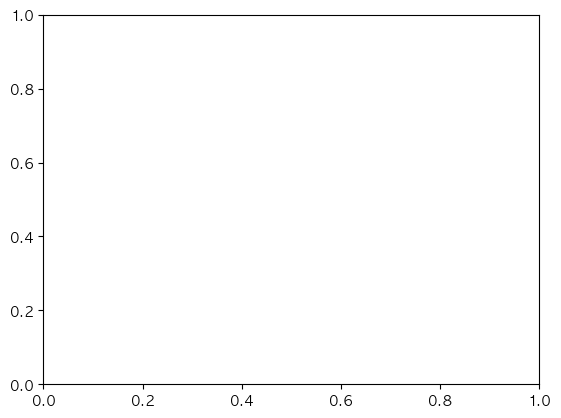

In [11]:
# [DRAW] heatmap plot

HeatmapFigure.draw_heatmap(
    tag_idx_to_name_dict=model.tag_idx_to_name,
    tags_corr=model.arr_tags_score,
    file_path=raw_corr_figure_file_path,
)


In [ ]:
# [DRAW] heatmap plot
HeatmapFigure.draw_heatmap(
    tag_idx_to_name_dict=model.tag_idx_to_name,
    tags_corr=model.arr_tags_score,
    file_path=raw_corr_figure_file_path,
)


In [ ]:

# 학습하기
model_params = BiasedEstimator.create_models_parameters(
    learning_rate=learning_rate,
    generalization=generalization,
)
estimator = BiasedEstimator(
    model=model,
    model_params=model_params,
)

# [DRAW] heatmap plot
HeatmapFigure.draw_heatmap(
    tag_idx_to_name_dict=model.tag_idx_to_name,
    tags_corr=estimator.model.arr_tags_score,
    file_path=biased_corr_figure_file_path,
)

In [ ]:


estimator.train(
    DecisionType.E_VIEW,
    n=dist_n,
    emit_iter_condition=iterations_threshold,
)
estimator.train(
    DecisionType.E_LIKE,
    n=dist_n,
    emit_iter_condition=iterations_threshold,
)
estimator.train(
    DecisionType.E_PURCHASE,
    n=dist_n,
    emit_iter_condition=iterations_threshold,
)
# [DRAW] heatmap plot
tags_weight: np.ndarray = estimator.arr_user_idx_to_weights.mean(axis=0)
weighted_tags_corr = np.multiply(
    estimator.arr_tags_score, tags_weight
)  # estimator.arr_tags_score * tags_weight
HeatmapFigure.draw_heatmap(
    tag_idx_to_name_dict=model.tag_idx_to_name,
    tags_corr=weighted_tags_corr,
    file_path=adjusted_corr_figure_file_path,
)

In [ ]:
# 예측 점수를 기준으로 추천하기
recommender = ScoreBasedRecommender(estimator=estimator)
recommender.prediction()

# 성능평가하기
evaluator = IRMetricsEvaluator(
    recommender=recommender,
    file_path=testset_file_path,
)
# evaluator.threshold_eval([round(th, 1) for th in np.arange(0.1, 1.1, 0.1)])
evaluator.top_n_eval(top_n_conditions=top_n_conditions)
evaluator.evlautions_summary_df().to_csv(path_or_buf=results_summary_path)
